In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def center_of_mass(image):
    x_sum = np.sum([np.sum(np.flatnonzero(x)) for x in image])
    y_sum = np.sum([np.sum(np.flatnonzero(x)) for x in np.rot90(image)])
    mass = np.sum(image)
    return (x_sum / mass, y_sum / mass)

In [3]:
def get_boundaries(image):
    left = np.min([np.min(np.flatnonzero(x), initial=10e10) for x in image])
    top = np.min([np.min(np.flatnonzero(x), initial=10e10) for x in np.rot90(image)])
    right = np.max([np.max(np.flatnonzero(x), initial=-10e10) for x in image])
    bottom = np.max([np.max(np.flatnonzero(x), initial=-10e10) for x in np.rot90(image)])
    return top, right, bottom, left

def get_corners(boundaries):
    top, right, bottom, left = boundaries
    return (left, top), (right, top), (left, bottom), (right, bottom)

In [4]:
def get_sizes(boundaries):
    top, right, bottom, left = boundaries
    return right - left, bottom - top

In [5]:
def get_surrounding_region(point, expansion=1):
    x, y = int(point[0]), int(point[1])
    region = []
    for i in range(x - expansion, x + expansion + 1):
        for j in range(y - expansion, y + expansion + 1):
            region.append((i, j))
    return region

In [6]:
def image_to_vector(image, label):
    # get center of mass
    center = center_of_mass(image)
    # get center of mass surroindings (9x9 square)
    region = np.array(get_surrounding_region(center))
    values = image[region[:,1], region[:,0]]
    # get 'painted' proportion
    boundaries = get_boundaries(image)
    size = get_sizes(boundaries)
    mass = np.sum(image)
    proportion = mass / (size[0] * size[1])
    return [proportion, *values, label]

## Ejemplo

Se incluye a modo de ejemplo la ejecución de las operaciones sobre una imagen, pero que después será hecho sobre todas las imagenes, incluida la que se quiera _evaluar_. Primero se obtiene el centro y los bordes _reales_ de la imagen, para luego proceder a mostrar la imagen, junto con el centro de masa y las esquinas de la imagen. Se calcula también el vector que se usará para una simple regresión lineal.

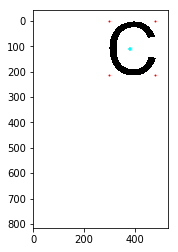

In [7]:
X = np.load('dataset/c_100.npy')

center = center_of_mass(X)
boundaries = get_boundaries(X)
corners = np.array(get_corners(boundaries))
vector = image_to_vector(image=X, label=0)

plt.imshow(X, cmap='Greys',  interpolation='nearest')
plt.scatter(*center, color='cyan', marker='+', s=10)
plt.scatter(*zip(*corners), color='red', s=1)
plt.show()

## Entrenamiento

En esta fase se utilizaran todas las funciones definidas anteriormente pero esta vez para, utilizando el dataset, deducir los parámetros adecuados para cada uno de los elementos del vector.

In [8]:
train_size = 400
c_names = [i for i in os.listdir('dataset') if i.startswith('c')]
s_names = [i for i in os.listdir('dataset') if i.startswith('s')]

np.random.shuffle(c_names)
np.random.shuffle(s_names)

train_c_names = c_names[:train_size]
train_s_names = s_names[:train_size]

test_c_names = c_names[train_size:]
test_s_names = s_names[train_size:]

In [9]:
c_train_images = []
for name in train_c_names:
    c_train_images.append(np.load(f'dataset/{name}'))
    
s_train_images = []
for name in train_s_names:
    s_train_images.append(np.load(f'dataset/{name}'))

In [10]:
c_train_vectors = [image_to_vector(img, 0) for img in c_train_images]

In [11]:
s_train_vectors = [image_to_vector(img, 1) for img in s_train_images]

In [12]:
data = np.array(c_train_vectors + s_train_vectors)
np.random.shuffle(data)

X = data[:,:-1]
y = data[:,-1]

In [13]:
learned_parameters = np.linalg.lstsq(X, y, rcond=None)[0]

In [14]:
learned_parameters

array([1.52370782e-17, 1.11111111e-01, 1.11111111e-01, 1.11111111e-01,
       1.11111111e-01, 1.11111111e-01, 1.11111111e-01, 1.11111111e-01,
       1.11111111e-01, 1.11111111e-01])

Como se aprecia, los parámetros muestran que lo único relevante es el centro de masa de la imagen, de hecho, que cada uno de los nueve puntos es igualmente relevante. Y que la proporción de masa sobre el tamaño del marco no es importante (el primer parámetro).

Para no perder la generalidad del procedimiento, se consideraran todos los parámetros aprendidos para evaluar ejemplares, sin embargo se podría simplificar la regla a únicamente extraer el centro de masa y obtener si es un 1 o un 0.

## Testing

Para esta sección se utiliza la fracción del dataset que no se utilizó para "entrenar" y se espera que el desempeño sea de un 100%, por lo simple del experimento. Para esto, se realiza la conversión de cada imagen a _evaluar_ a vector, de la misma manera que antes, y se realiza el producto punto con los parámetros aprendidos.

In [15]:
c_test_images = []
for name in test_c_names:
    c_test_images.append(np.load(f'dataset/{name}'))
    
s_test_images = []
for name in test_s_names:
    s_test_images.append(np.load(f'dataset/{name}'))

In [16]:
c_test_vectors = [image_to_vector(img, None) for img in c_test_images]
s_test_vectors = [image_to_vector(img, None) for img in s_test_images]

In [17]:
predicted_c = np.dot(np.array(c_test_vectors)[:,:-1], learned_parameters)
predicted_s = np.dot(np.array(s_test_vectors)[:,:-1], learned_parameters)
results_c = np.around(predicted_c.astype(int))
results_s = np.around(predicted_s.astype(int))
all(np.array(results_c) == np.zeros(len(results_c))), all(np.array(results_s) == np.ones(len(results_s)))

(True, True)

Como se observa, todos los ejemplares, al procesarlos y calcularles el tipo, entregan 0 para las 'c' y 1 para las 's'.

In [18]:
def reconocedorSC(X):
    vector = image_to_vector(X, None)
    return int(round(np.dot(vector[:-1], learned_parameters)))

In [19]:
reconocedorSC(np.load('S01.npy'))

1